# Differential Expression with limma-voom pipeline - Genes

In [1]:
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(calibrate))
suppressMessages(library(ggplot2))
suppressMessages(library(limma))
suppressMessages(library(edgeR))
suppressMessages(library(sva))

## Prepare Data

### Load gene counts

In [2]:
load("../../../inputs/phase3/_m/count_data/caudate_brainseq_phase3_hg38_rseGene_merged_n464.rda")

In [2]:
rse_gene

class: RangedSummarizedExperiment 
dim: 58037 464 
metadata(0):
assays(1): counts
rownames(58037): ENSG00000223972.5 ENSG00000227232.5 ...
  ENSG00000210195.2 ENSG00000210196.2
rowData names(10): Length gencodeID ... NumTx gencodeTx
colnames(464): R12864 R12865 ... R13503 R13504
colData names(71): BrNum RNum ... RNum.1 FlowCell

### Load genotype data

In [4]:
load("../../../inputs/phase3/_m/genotype_data/BrainSeq_Phase3_Caudate_RiboZero_MDSonly_n464.rda")
colData(rse_gene) = cbind(colData(rse_gene), mds)
rse_gene

class: RangedSummarizedExperiment 
dim: 58037 464 
metadata(0):
assays(1): counts
rownames(58037): ENSG00000223972.5 ENSG00000227232.5 ...
  ENSG00000210195.2 ENSG00000210196.2
rowData names(10): Length gencodeID ... NumTx gencodeTx
colnames(464): R12864 R12865 ... R13503 R13504
colData names(81): BrNum RNum ... snpPC9 snpPC10

### Subset and recode

In [5]:
keepIndex = which((rse_gene$Dx == 'Control' | rse_gene$Dx == 'Schizo') & rse_gene$Age > 17)
rse_gene = rse_gene[, keepIndex]
rse_gene

class: RangedSummarizedExperiment 
dim: 58037 394 
metadata(0):
assays(1): counts
rownames(58037): ENSG00000223972.5 ENSG00000227232.5 ...
  ENSG00000210195.2 ENSG00000210196.2
rowData names(10): Length gencodeID ... NumTx gencodeTx
colnames(394): R12864 R12865 ... R13503 R13504
colData names(81): BrNum RNum ... snpPC9 snpPC10

In [6]:
rse_gene$Dx = factor(rse_gene$Dx, levels = c("Control", "Schizo"))
rse_gene$Sex <- factor(rse_gene$Sex)

In [7]:
# Function from jaffelab github
merge_rse_metrics <- function(rse) {
    stopifnot(is(rse, 'RangedSummarizedExperiment'))
    stopifnot(
        c('concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
          'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
          'mitoMapped', 'totalMapped') %in%
            colnames(SummarizedExperiment::colData(rse))
    )

    stopifnot(all(sapply(c(
        'concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
        'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
        'mitoMapped', 'totalMapped'), function(var) {
            is(colData(rse)[, var], 'List')
        })
    ))

    rse$concordMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$concordMapRate, rse$numReads)
    rse$overallMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$overallMapRate, rse$numReads)
    rse$mitoRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$mitoRate, rse$numMapped)
    rse$rRNA_rate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$rRNA_rate, rse$numMapped)
    rse$totalAssignedGene = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$totalAssignedGene, rse$numMapped)

    rse$numMapped = sapply(rse$numMapped, sum)
    rse$numReads = sapply(rse$numReads, sum)
    rse$numUnmapped = sapply(rse$numUnmapped, sum)
    rse$mitoMapped = sapply(rse$mitoMapped, sum)
    rse$totalMapped = sapply(rse$totalMapped, sum)
    return(rse)
}

In [8]:
rse_gene <- merge_rse_metrics(rse_gene)

In [9]:
rse_gene$ERCCsumLogErr <- mapply(function(r, n) {
        sum(r * n)/sum(n)
    }, rse_gene$ERCCsumLogErr, rse_gene$numReads)
colData(rse_gene)$RIN = sapply(colData(rse_gene)$RIN,"[",1)

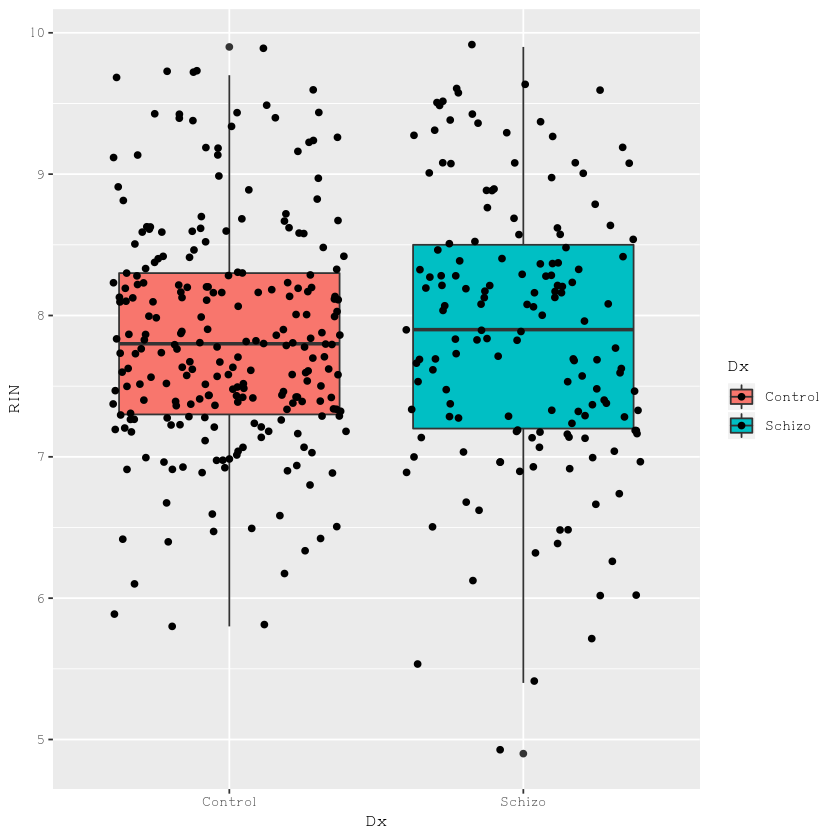

In [10]:
ggplot(data.frame(colData(rse_gene)), aes(x=Dx, y=RIN, fill=Dx)) + geom_boxplot() + geom_jitter()

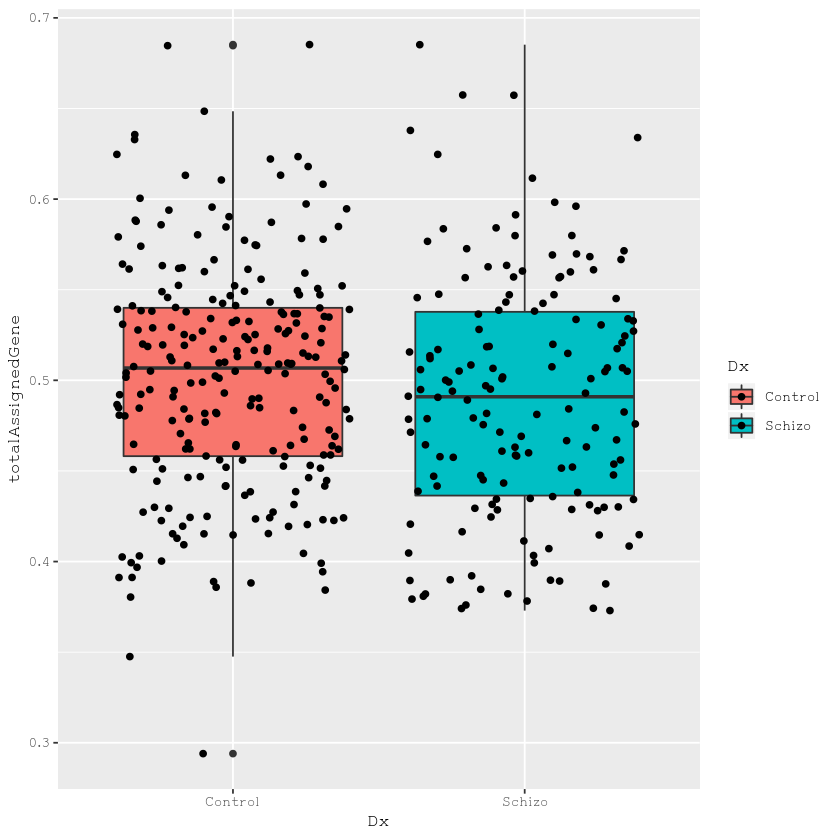

In [11]:
ggplot(data.frame(colData(rse_gene)), aes(x=Dx, y=totalAssignedGene, fill=Dx)) + geom_boxplot() + geom_jitter()

### Generate DGEList

In [12]:
x <- DGEList(counts=assays(rse_gene)$counts, 
             genes=rowData(rse_gene), 
             samples=colData(rse_gene))

### Filtering low counts

In [13]:
design0 <- model.matrix(~Dx, data=x$samples)
keep.x <- filterByExpr(x, design=design0)
x <- x[keep.x, , keep.lib.sizes=FALSE]
print(paste('There are:', sum(keep.x), 'features left!', sep=' '))

[1] "There are: 22969 features left!"


### Normalize counts

In [14]:
x <- calcNormFactors(x, method="TMM")

## Differential Expression Analysis

### Design matrix

In [15]:
mod = model.matrix(~Dx + Age + Sex + mitoRate +
        rRNA_rate + totalAssignedGene + RIN +
        ERCCsumLogErr + overallMapRate +
        snpPC1 + snpPC2 + snpPC3 + snpPC4 + snpPC5,
        data = colData(rse_gene))

In [16]:
colnames(mod) <- gsub("Dx", "", colnames(mod))
colnames(mod) <- gsub("SexM", "Male", colnames(mod))
colnames(mod) <- gsub("\\(Intercept\\)", "Intercept",
                         colnames(mod))

In [17]:
head(mod, 2)

,Intercept,Schizo,Age,Male,mitoRate,rRNA_rate,totalAssignedGene,RIN,ERCCsumLogErr,overallMapRate,snpPC1,snpPC2,snpPC3,snpPC4,snpPC5
R12864,1,1,42.98,0,0.03265387,8.675159e-05,0.5148545,9.6,-59.97567,0.9093498,0.0493213,-0.00560004,-1.25945e-03,0.00109117,0.000905945
R12865,1,1,53.12,1,0.01978740,6.976684e-05,0.5207789,9.5,-45.71034,0.8734840,0.0630991,-0.00499613,2.93356e-05,0.00104552,-0.001195790


### Load degradation matrix

In [18]:
load("../../../inputs/phase3/_m/count_data/degradation_rse_phase3_caudate.rda")
cov_rse_caudate = cov_rse_caudate[, keepIndex]

### Calculate qSVAs

In [19]:
dm <- assays(cov_rse_caudate)$counts
qSV <- qsva(dm)

In [20]:
if("TRUE" %in% grepl("_", rownames(qSV))){# Remove underscore if needed                       
    rownames(qSV) <- sapply(strsplit(rownames(qSV), "_"), "[", 1)
}

### Merge models

In [21]:
modQsva <- merge(mod, qSV, by=0, all=FALSE)
rownames(modQsva) <- modQsva$Row.names
modQsva  <- modQsva[,-1]

In [22]:
dim(modQsva)[1] == dim(x$counts)[2]

[1] TRUE

### Preform voom

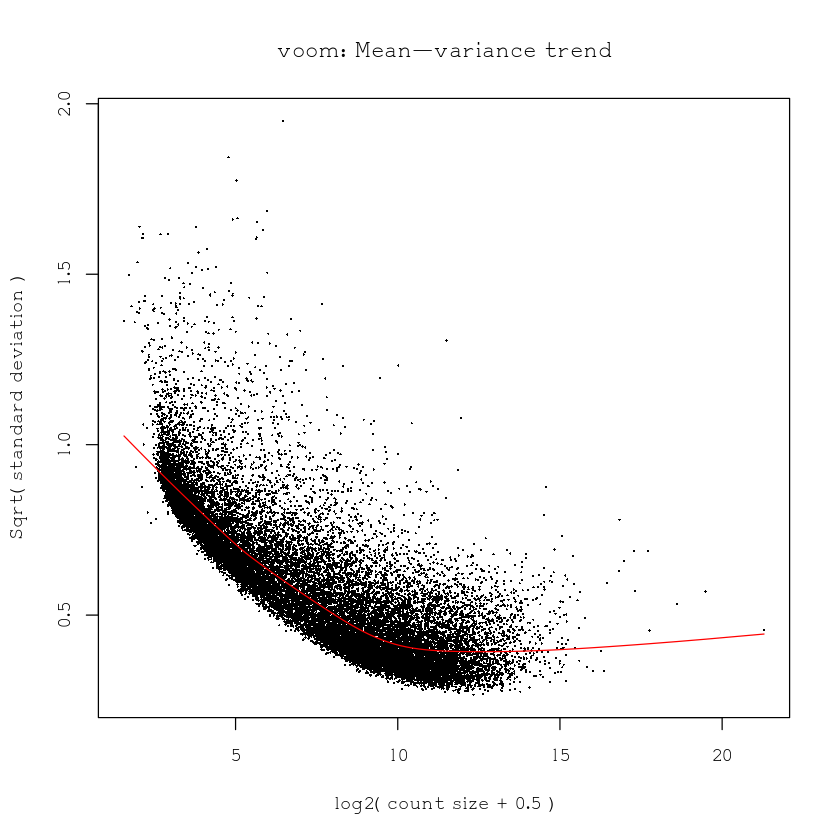

In [23]:
v <- voom(x, modQsva, plot=TRUE)

In [24]:
feature = 'genes'
dir.create(feature)

In [25]:
save(v, file=paste0('../_m/',feature,'/voomSVA.RData'))

### Calculate residuals

In [26]:
null_model = v$design[, !(names(v$design) %in% c("Schizo"))]
fit_res <- lmFit(v, design=null_model)
res = v$E - ( fit_res$coefficients %*% t(null_model) )
res_sd = apply(res, 1, sd)
res_mean = apply(res, 1, mean)

### Normalize residuals and write to file

In [27]:
res_norm = (res - res_mean) / res_sd
write.table(res_norm, file=paste0('../_m/', feature, '/residualized_expression.tsv'),
            sep="\t", quote=FALSE)

### Fit model with limma

In [28]:
fit0 <- lmFit(v, modQsva)
contr.matrix <- makeContrasts(CtrlvsSZ = Schizo, 
                              levels=colnames(modQsva))
fit <- contrasts.fit(fit0, contrasts=contr.matrix)

### Calculate differential expression with eBayes

In [29]:
esv <- eBayes(fit)

In [30]:
options(width=200)
top0 <- topTable(esv, coef=1, number=Inf, sort.by="P")
sigTest <- decideTests(esv)

In [31]:
top <- merge(top0, sigTest, by=0)
rownames(top) <- top$Row.names
top <- top[,-1]
top <- top[order(top$P.Value), ]
top <- subset(top, select=-gencodeTx)
dim(top)

[1] 22969    17

In [32]:
write.table(top, file=paste0('../_m/', feature, "/diffExpr_szVctl_full.txt"),
            sep='\t', row.names=TRUE, quote=FALSE)

### Subset via FDR

In [33]:
top.fdr <- top[top$adj.P.Val<=0.05,]
print(paste('There are:', dim(top.fdr)[1], 'DE features!'))

[1] "There are: 2699 DE features!"


In [34]:
subset(top.fdr, Symbol == 'CACNA1I')

,Length,gencodeID,ensemblID,gene_type,Symbol,EntrezID,Class,meanExprs,NumTx,gencodeTx,logFC,AveExpr,t,P.Value,adj.P.Val,B,CtrlvsSZ
ENSG00000100346.17,10792,ENSG00000100346.17,ENSG00000100346,protein_coding,CACNA1I,8911,InGen,2.660744,5,ENST0000....,-0.09681621,5.79444,-3.006159,0.002825414,0.03017872,-2.603505,-1


In [35]:
write.table(top.fdr, file=paste0('../_m/', feature, "/diffExpr_szVctl_FDR05.txt"),
            sep='\t', row.names=TRUE, quote=FALSE)

## Volcano and MA plots

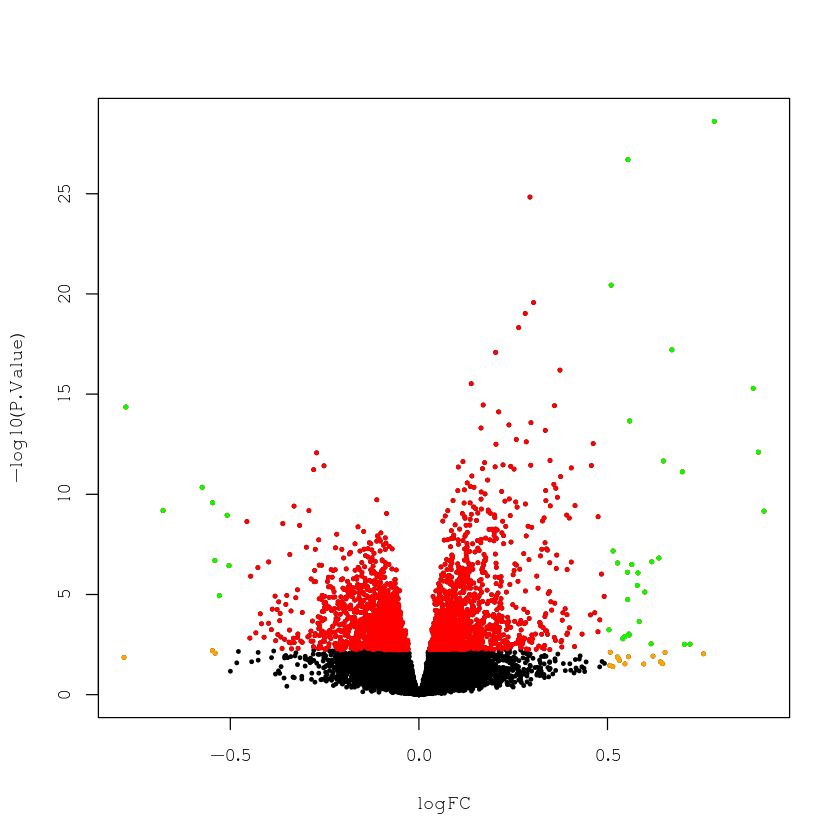

In [36]:
with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                          pch=20, col='red', cex=0.6))
with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                          pch=20, col='orange', cex=0.6))
with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
     points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))

In [37]:
pdf(file=paste0('../_m/', feature, "/volcanoPlot.pdf"), 8, 6)
with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                          pch=20, col='red', cex=0.6))
with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                          pch=20, col='orange', cex=0.6))
with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
     points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
dev.off()

png 
  2

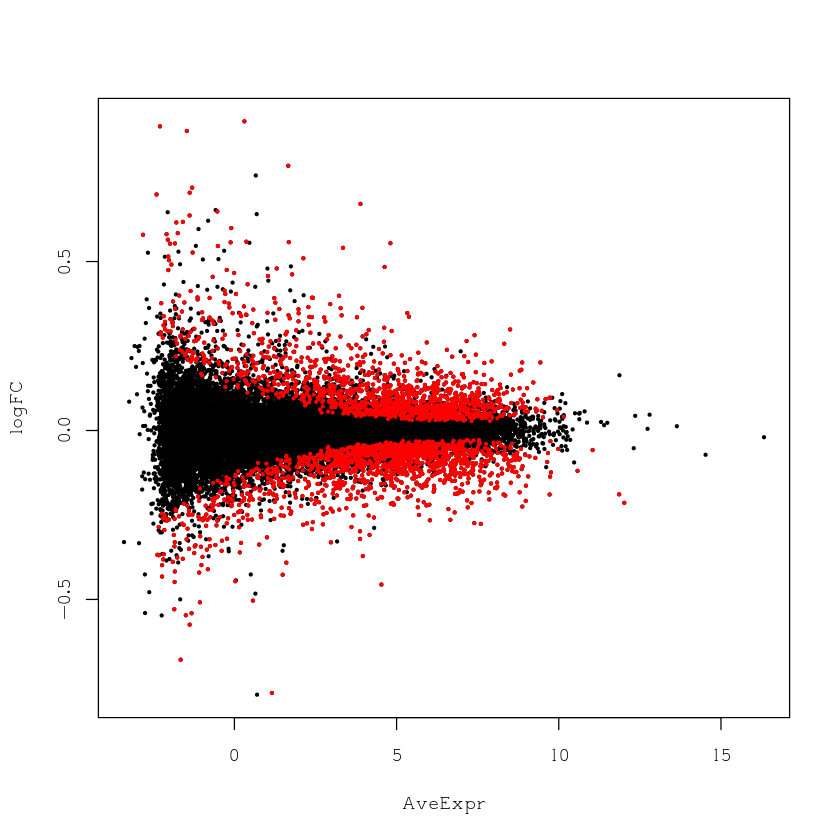

In [38]:
with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
with(subset(top, adj.P.Val<0.05),
     points(AveExpr, logFC, col="red", pch=20, cex=0.5))

In [39]:
pdf(file=paste0('../_m/', feature, "/MAplot.pdf"), 8, 6)
with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
with(subset(top, adj.P.Val<0.05),
     points(AveExpr, logFC, col="red", pch=20, cex=0.5))
dev.off()

png 
  2

## Repreducibility Information

In [40]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2019-06-06 15:35:17 EDT"

    user   system  elapsed 
3161.182   47.897  287.152 

- Session info -------------------------------------------------------------------------------------------------------
 setting  value                       
 version  R version 3.5.0 (2018-04-23)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  C                           
 ctype    C                           
 tz       America/New_York            
 date     2019-06-06                  

- Packages -----------------------------------------------------------------------------------------------------------
 package              * version   date       lib source        
 annotate               1.60.0    2018-10-30 [1] Bioconductor  
 AnnotationDbi          1.44.0    2018-10-30 [1] Bioconductor  
 assertthat             0.2.0     2017-04-11 [1] CRAN (R 3.5.0)
 base64enc              0.1-3     2015-07-28 [1] CRAN (R 3.5.0)
 bindr                  0.1.1     2018-03-13 [1] CR